# **Support Vector Machine and Proposed method**
## The following project implements multiclass classification on MNIST dataset with balanced, imbalanced and noisy data using Support Vector Machine.
    


# Libraries

In [566]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from sklearn.svm import SVC, LinearSVC
#from thundersvm import SVC
import pandas as pd
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,precision_recall_curve,average_precision_score,PrecisionRecallDisplay,roc_curve,auc,f1_score
import numpy
import matplotlib.pyplot as matplot
from collections import Counter
from imblearn.datasets import make_imbalance
import numpy as np
import os
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.preprocessing import label_binarize
from keras.utils import np_utils
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import BaggingClassifier
import keras
from imblearn.over_sampling import SMOTE
import warnings

In [567]:
warnings.filterwarnings("ignore")

# Functions to be implemented

In [568]:
def load_data():
  (X_train,y_train),(X_test,y_test) = mnist.load_data() 
  return X_train,y_train,X_test,y_test

In [569]:
#Preprocess the data such as transforming into one-hot-encode labels, reshaping.

def preprocess(X_train,y_train,X_test,y_test):
  y_train_clean = np.copy(y_train)
  Y_clean_train = np.copy(y_train)
  Y_clean_test = np.copy(y_test)
# # one-hot-encode the labels
  y_train_clean = np_utils.to_categorical(y_train_clean, 10)
  y_train = np_utils.to_categorical(y_train, 10)
  y_test = np_utils.to_categorical(y_test, 10)

  Y_train = np.argmax(y_train, axis=1)
  Y_test = np.argmax(y_test, axis=1)

  X_train = X_train.reshape(len(X_train),-1)
  X_test = X_test.reshape(len(X_test),-1)

  return X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train

In [570]:
# Train the model and returns the predicted labels. Used baggingclassifier to fit the model on subset of the data

def train_model(X_train,Y_train,X_test,max_samples):
  # Create a classifier: a support vector classifier with bagging classifier
  clf = BaggingClassifier(svm.SVC(),n_estimators=10,max_samples=max_samples,bootstrap=False,n_jobs=-1,verbose=True)
  # Learn the digits on the train subset by fitting the model
  clf.fit(X_train, Y_train)
  Y_score = clf.decision_function(X_test)
  # Predict labels from test data
  predicted = clf.predict(X_test)
  return predicted,clf,Y_score

In [571]:
#Plot the ROC curve

def plot_ROC(Y_test,Y_score):
  plt.figure(figsize=(10, 10))
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  colors = cycle(['blue', 'red', 'green','yellow','black','cyan','grey','pink','purple','orange'])
  for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic for multi-class data')
  plt.legend(loc="lower right")
  plt.show()

In [572]:
def ratio_func(y, multiplier, minority_class):
  target_stats = Counter(y)
  return {minority_class: int(multiplier * target_stats[minority_class])}

In [573]:
# Create an imbalanced dataset by removing the data with random proportions from each class 
def Imbalanced(X_train,y_train):
  X_resampled=X_train.copy()
  y_resampled=y_train.copy()
  # To keep data with random proportions (class 1:33% data,class 2:45% data,class 3:67% data,class 4:100% data,class 5:10% data,class 6:15% data,class 7:50% data,class 8: 30% data,class 9:100% data,class 10: 100% data
  multipliers = [0.33, 0.45, 0.67, 1.0, 0.1,0.15,0.5,0.3,1.0,1.0]
  cls= [0,1,2,3,4,5,6,7,8,9]

  i = 0
  for multiplier in multipliers:
    X_resampled,y_resampled = make_imbalance(X_resampled,y_resampled,sampling_strategy=ratio_func,**{"multiplier": multiplier, "minority_class":cls[i]})
    i=i+1
  df = pd.DataFrame({"x":y_resampled,"hh":[1]*len(y_resampled)})
  df['x'].hist(figsize = (5, 5))
  return X_resampled,y_resampled

In [574]:
def other_class(n_classes, current_class):
  if current_class < 0 or current_class >= n_classes:
    error_str = "class_ind must be within the range (0, nb_classes - 1)"
    raise ValueError(error_str)
  other_class_list = list(range(n_classes))
  other_class_list.remove(current_class)
  other_class = np.random.choice(other_class_list)
  return other_class

In [575]:
# Adding symmetric noise

def SYM_Noise(X_train,y_train,noise_ratio):
  y_train_clean = np.copy(y_train)
  n_samples = y_train.shape[0]
  n_noisy = int(noise_ratio * n_samples / 100)
  class_index = [np.where(y_train_clean == i)[0] for i in range(10)]
  class_noisy = int(n_noisy / 10)
  noisy_idx = []
  for d in range(10):
    noisy_class_index = np.random.choice(class_index[d], class_noisy, replace=True)
    noisy_idx.extend(noisy_class_index)
  for i in noisy_idx:
    y_train[i] = other_class(n_classes=10, current_class=y_train[i])
  print("Print noisy label generation statistics:")
  for i in range(10):
    n_noisy = np.sum(y_train == i)
    print("Noisy class %s, has %s samples." % (i, n_noisy))
  return X_train,y_train

In [576]:
#Adding Assymmetric noise

def ASYM_Noise(X_train,y_train,source_class,target_class,noise_ratio):
  y_train_clean = np.copy(y_train)
  for s, t in zip(source_class, target_class):
    cls_idx = np.where(y_train_clean == s)[0]
    n_noisy = int(noise_ratio * cls_idx.shape[0] / 100)
    noisy_sample_index = np.random.choice(cls_idx, n_noisy, replace=True)
    y_train[noisy_sample_index] = t
  print("Print noisy label generation statistics:")
  for i in range(10):
    n_noisy = np.sum(y_train == i)
    print("Noisy class %s, has %s samples." % (i, n_noisy))
  return X_train,y_train

In [577]:
#Display classification report

def classification_report(Y_test,predicted):
  print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(Y_test, predicted)}\n")

In [578]:
#Display confusion matric

def confusion_matrix(Y_test,predicted):
  cm = metrics.confusion_matrix(Y_test, predicted, labels=clf.classes_)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
  disp.plot()
  plt.show()

# Balanced Dataset

In [579]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
#X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,train_size=0.2,random_state=23)

In [580]:
# Data in each class

pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count()

,hh
x,
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851


In [581]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (60000, 784)
Y_train: (60000,)
X_test: (10000, 784)
Y_test (10000,)


In [582]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   18.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.6min finished


In [583]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.94      0.95      0.94      1010
           4       0.94      0.96      0.95       982
           5       0.94      0.93      0.94       892
           6       0.96      0.97      0.96       958
           7       0.96      0.93      0.94      1028
           8       0.95      0.92      0.94       974
           9       0.94      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000




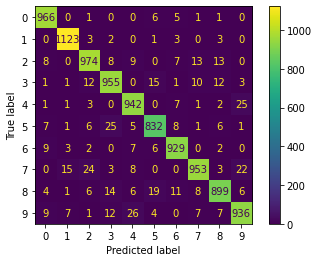

In [584]:
confusion_matrix(Y_test,predicted)

In [585]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.9504845565148615
Accuracy:0.9509
Recall:0.9504845565148615
f1 score:0.9503477606290203


In [586]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ovr')

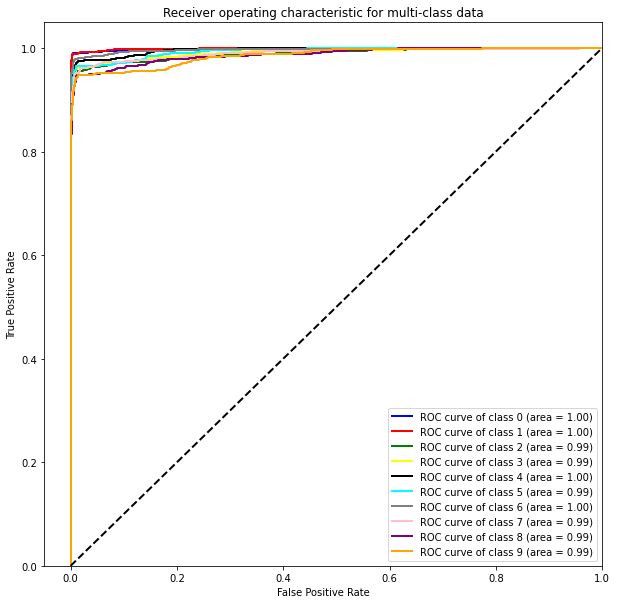

In [587]:
plot_ROC(Y_test,Y_score)

In [588]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.9926885121647728


# Imbalanced MNIST

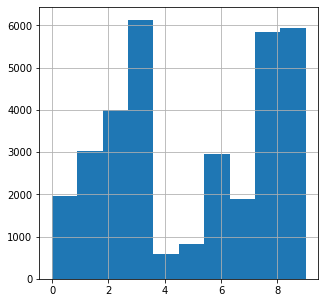

In [589]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
X_train,Y_train = Imbalanced(X_train,Y_train)
# X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.2)

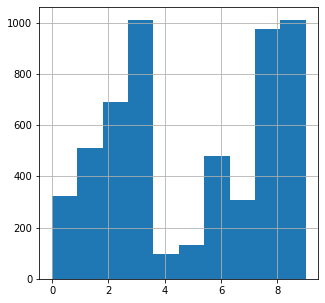

In [590]:
X_test, Y_test = Imbalanced(X_test,Y_test)

In [591]:
df1 = pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count().reset_index()
df2 = pd.DataFrame({"x":Y_clean_train,"hh":[1]*len(Y_clean_train)}).groupby(["x"]).count().reset_index()

In [592]:
df1

,x,hh
0,0,1954
1,1,3033
2,2,3991
3,3,6131
4,4,584
5,5,813
6,6,2959
7,7,1879
8,8,5851
9,9,5949


In [593]:
df2

,x,hh
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [594]:
print("X_train:", X_train.shape)
print("y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("y_test", Y_test.shape)

X_train: (33144, 784)
y_train: (33144,)
X_test: (5535, 784)
y_test (5535,)


In [595]:
X_train,Y_train = shuffle(X_train,Y_train)
X_test,Y_test = shuffle(X_test,Y_test)

In [596]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   31.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   31.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   31.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   31.7s finished


In [597]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       323
           1       0.96      0.98      0.97       510
           2       0.95      0.94      0.95       691
           3       0.93      0.97      0.95      1010
           4       1.00      0.28      0.43        98
           5       0.98      0.49      0.65       133
           6       0.95      0.97      0.96       479
           7       0.94      0.82      0.88       308
           8       0.93      0.96      0.94       974
           9       0.89      0.96      0.92      1009

    accuracy                           0.93      5535
   macro avg       0.95      0.83      0.86      5535
weighted avg       0.93      0.93      0.93      5535




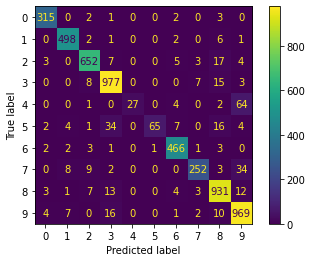

In [598]:
confusion_matrix(Y_test,predicted)

In [599]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.9483524954859892
Accuracy:0.9308039747064137
Recall:0.9483524954859892
f1 score:0.8612898302109316


In [600]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ova')

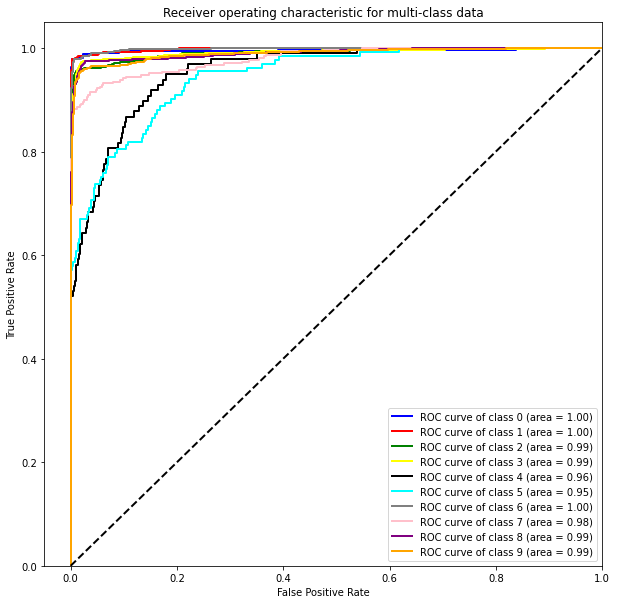

In [601]:
plot_ROC(Y_test,Y_score)

In [602]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.9834356057834917


# Symmetric Noise with Balanced MNIST Dataset

In [603]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
# X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,train_size=0.2,random_state=23)

In [604]:
X_train,Y_train = SYM_Noise(X_train,Y_train,60)

Print noisy label generation statistics:
Noisy class 0, has 5869 samples.
Noisy class 1, has 6638 samples.
Noisy class 2, has 5951 samples.
Noisy class 3, has 6101 samples.
Noisy class 4, has 5898 samples.
Noisy class 5, has 5645 samples.
Noisy class 6, has 5887 samples.
Noisy class 7, has 6270 samples.
Noisy class 8, has 5815 samples.
Noisy class 9, has 5926 samples.


In [605]:
df1 = pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count().reset_index()
df2 = pd.DataFrame({"x":Y_clean_train,"hh":[1]*len(Y_clean_train)}).groupby(["x"]).count().reset_index()

In [606]:
df1

,x,hh
0,0,5869
1,1,6638
2,2,5951
3,3,6101
4,4,5898
5,5,5645
6,6,5887
7,7,6270
8,8,5815
9,9,5926


In [607]:
df2

,x,hh
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [608]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (60000, 784)
Y_train: (60000,)
X_test: (10000, 784)
Y_test (10000,)


In [609]:
X_train,Y_train = shuffle(X_train,Y_train)
X_test,Y_test = shuffle(X_test,Y_test)

In [610]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   41.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.9min finished


In [611]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.95      0.99      0.97      1135
           2       0.95      0.91      0.93      1032
           3       0.93      0.94      0.93      1010
           4       0.92      0.95      0.93       982
           5       0.95      0.92      0.93       892
           6       0.94      0.97      0.96       958
           7       0.94      0.93      0.93      1028
           8       0.95      0.90      0.92       974
           9       0.93      0.91      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000




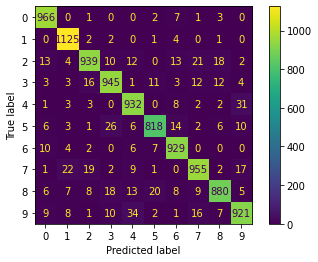

In [612]:
confusion_matrix(Y_test,predicted)

In [613]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.9409236491942596
Accuracy:0.941
Recall:0.9409236491942596
f1 score:0.9404090028697814


In [614]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ovr')

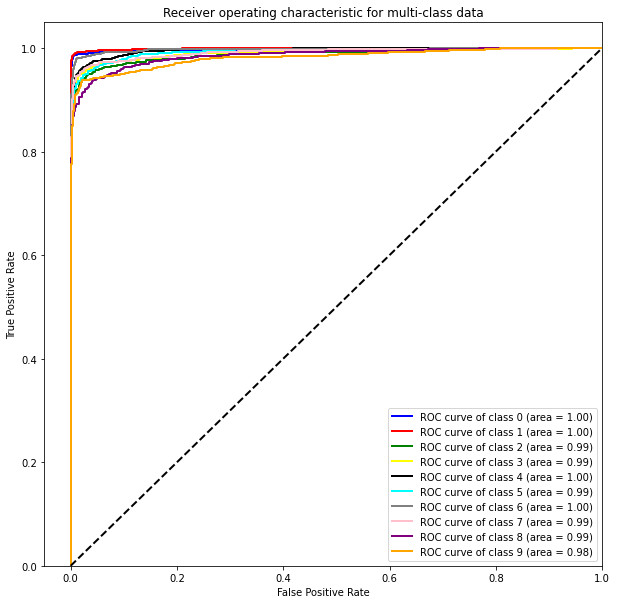

In [615]:
plot_ROC(Y_test,Y_score)

In [616]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.9917272757254851


# Asymmetric Noise with Balanced MNIST Dataset

In [617]:
source_class = [7, 2, 3, 5, 6, 0, 4]
target_class = [1, 7, 8, 6, 5, 4, 1]

noise_ratio = 60

In [618]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
# X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,train_size=0.2,random_state=23)

In [619]:
X_train,Y_train = ASYM_Noise(X_train,Y_train,source_class,target_class,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 3264 samples.
Noisy class 1, has 12217 samples.
Noisy class 2, has 3269 samples.
Noisy class 3, has 3380 samples.
Noisy class 4, has 5840 samples.
Noisy class 5, has 5638 samples.
Noisy class 6, has 5701 samples.
Noisy class 7, has 6140 samples.
Noisy class 8, has 8602 samples.
Noisy class 9, has 5949 samples.


In [620]:
df1 = pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count().reset_index()
df2 = pd.DataFrame({"x":Y_clean_train,"hh":[1]*len(Y_clean_train)}).groupby(["x"]).count().reset_index()

In [621]:
df1

,x,hh
0,0,3264
1,1,12217
2,2,3269
3,3,3380
4,4,5840
5,5,5638
6,6,5701
7,7,6140
8,8,8602
9,9,5949


In [622]:
df2

,x,hh
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [623]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (60000, 784)
Y_train: (60000,)
X_test: (10000, 784)
Y_test (10000,)


In [624]:
X_train,Y_train = shuffle(X_train,Y_train)
X_test,Y_test = shuffle(X_test,Y_test)

In [625]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   26.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   26.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.7min finished


In [626]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.98      0.92      0.94       980
           1       0.60      0.99      0.75      1135
           2       0.98      0.76      0.86      1032
           3       0.98      0.62      0.76      1010
           4       0.84      0.60      0.70       982
           5       0.84      0.82      0.83       892
           6       0.87      0.86      0.87       958
           7       0.81      0.71      0.76      1028
           8       0.67      0.94      0.78       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.81     10000
   macro avg       0.85      0.81      0.82     10000
weighted avg       0.85      0.81      0.81     10000




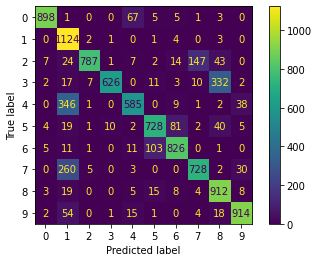

In [627]:
confusion_matrix(Y_test,predicted)

In [628]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.8485763024036025
Accuracy:0.8128
Recall:0.8485763024036025
f1 score:0.8150335116593677


In [629]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ovr')

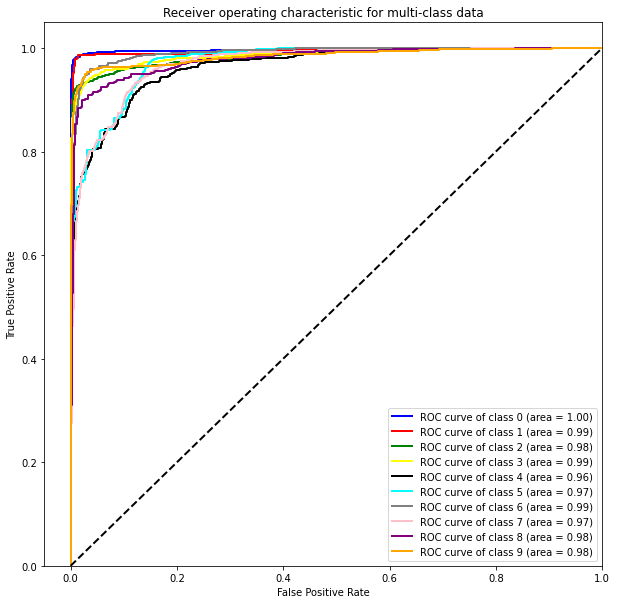

In [630]:
plot_ROC(Y_test,Y_score)

In [631]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.981891783495606


# Symmetric Noise with Imbalanced MNIST Dataset

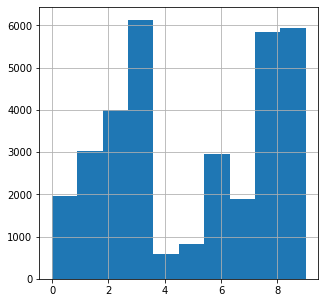

In [632]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
X_train,Y_train = Imbalanced(X_train,Y_train)
# X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=23)

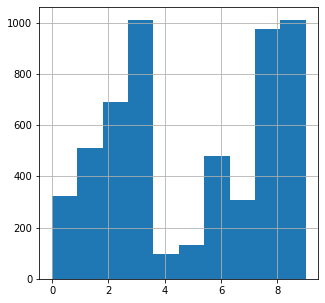

In [633]:
X_test, Y_test = Imbalanced(X_test,Y_test)

In [634]:
X_train,Y_train = SYM_Noise(X_train,Y_train,60)

Print noisy label generation statistics:
Noisy class 0, has 2046 samples.
Noisy class 1, has 2954 samples.
Noisy class 2, has 3754 samples.
Noisy class 3, has 5686 samples.
Noisy class 4, has 1429 samples.
Noisy class 5, has 1404 samples.
Noisy class 6, has 2848 samples.
Noisy class 7, has 2015 samples.
Noisy class 8, has 5468 samples.
Noisy class 9, has 5540 samples.


In [635]:
X_train,Y_train = shuffle(X_train,Y_train)
X_test,Y_test = shuffle(X_test,Y_test)

In [636]:
df1 = pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count().reset_index()
df2 = pd.DataFrame({"x":Y_clean_train,"hh":[1]*len(Y_clean_train)}).groupby(["x"]).count().reset_index()

In [637]:
df1

,x,hh
0,0,2046
1,1,2954
2,2,3754
3,3,5686
4,4,1429
5,5,1404
6,6,2848
7,7,2015
8,8,5468
9,9,5540


In [638]:
df2

,x,hh
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [639]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (33144, 784)
Y_train: (33144,)
X_test: (5535, 784)
Y_test (5535,)


In [640]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   13.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   46.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   46.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   46.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   46.4s finished


In [641]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       323
           1       0.97      0.99      0.98       510
           2       0.93      0.92      0.92       691
           3       0.88      0.97      0.92      1010
           4       0.00      0.00      0.00        98
           5       0.00      0.00      0.00       133
           6       0.95      0.94      0.95       479
           7       0.98      0.66      0.78       308
           8       0.89      0.95      0.92       974
           9       0.82      0.96      0.89      1009

    accuracy                           0.90      5535
   macro avg       0.74      0.73      0.73      5535
weighted avg       0.86      0.90      0.88      5535




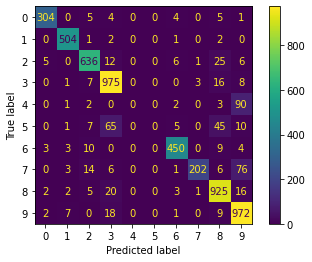

In [642]:
confusion_matrix(Y_test,predicted)

In [643]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.7372088721394323
Accuracy:0.8975609756097561
Recall:0.7372088721394323
f1 score:0.730760394182246


In [644]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ovr')

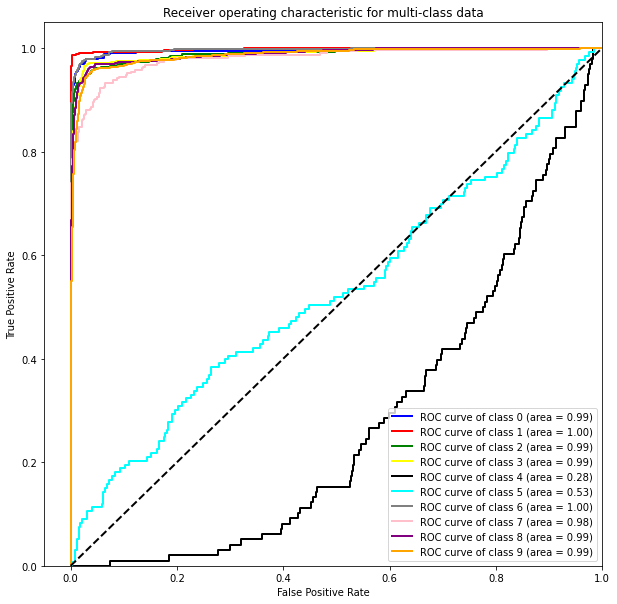

In [645]:
plot_ROC(Y_test,Y_score)

In [646]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.8729006130090002


# Asymmetric Noise with Imbalanced MNIST Dataset

In [647]:
source_class = [7, 2, 3, 5, 6, 0, 4]
target_class = [1, 7, 8, 6, 5, 4, 1]

noise_ratio = 60

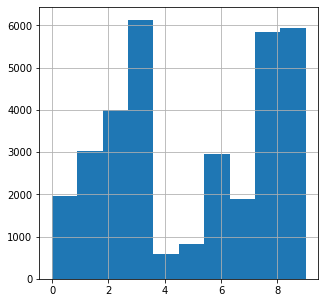

In [648]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
X_train,Y_train = Imbalanced(X_train,Y_train)
# X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=23)

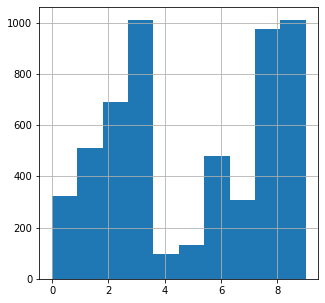

In [649]:
X_test, Y_test = Imbalanced(X_test,Y_test)

In [650]:
X_train,Y_train = ASYM_Noise(X_train,Y_train,source_class,target_class,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 1088 samples.
Noisy class 1, has 4131 samples.
Noisy class 2, has 2201 samples.
Noisy class 3, has 3376 samples.
Noisy class 4, has 1194 samples.
Noisy class 5, has 1781 samples.
Noisy class 6, has 1991 samples.
Noisy class 7, has 2827 samples.
Noisy class 8, has 8606 samples.
Noisy class 9, has 5949 samples.


In [651]:
df1 = pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count().reset_index()
df2 = pd.DataFrame({"x":Y_clean_train,"hh":[1]*len(Y_clean_train)}).groupby(["x"]).count().reset_index()

In [652]:
df1

,x,hh
0,0,1088
1,1,4131
2,2,2201
3,3,3376
4,4,1194
5,5,1781
6,6,1991
7,7,2827
8,8,8606
9,9,5949


In [653]:
df2

,x,hh
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [654]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (33144, 784)
Y_train: (33144,)
X_test: (5535, 784)
Y_test (5535,)


In [655]:
X_train,Y_train = shuffle(X_train,Y_train)
X_test,Y_test = shuffle(X_test,Y_test)

In [656]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    9.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   40.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   40.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   39.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   39.8s finished


In [657]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       323
           1       0.77      0.98      0.86       510
           2       0.98      0.74      0.84       691
           3       0.99      0.58      0.73      1010
           4       0.02      0.01      0.01        98
           5       0.14      0.11      0.12       133
           6       0.95      0.76      0.84       479
           7       0.56      0.49      0.52       308
           8       0.62      0.98      0.76       974
           9       0.86      0.96      0.91      1009

    accuracy                           0.78      5535
   macro avg       0.69      0.65      0.65      5535
weighted avg       0.81      0.78      0.77      5535




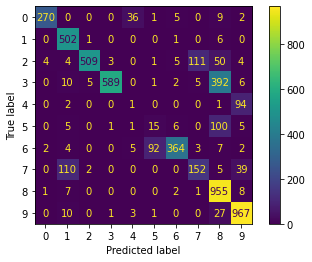

In [658]:
confusion_matrix(Y_test,predicted)

In [659]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.6852939504076556
Accuracy:0.7812104787714543
Recall:0.6852939504076556
f1 score:0.6504809279690031


In [660]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ovr')

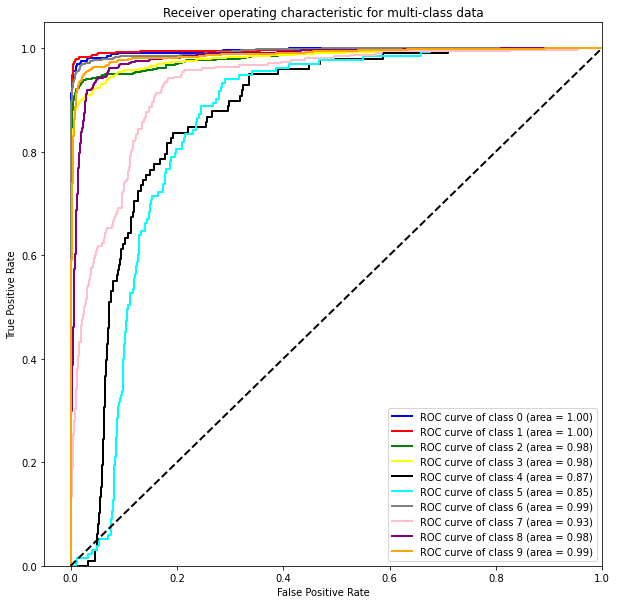

In [661]:
plot_ROC(Y_test,Y_score)

In [662]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.9569341690616827


# Proposed SVM

## Balanced Dataset with SMOTE

In [663]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
#X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,train_size=0.2,random_state=23)

In [664]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())

In [665]:
pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count()

,hh
x,
0,6742
1,6742
2,6742
3,6742
4,6742
5,6742
6,6742
7,6742
8,6742


In [666]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (67420, 784)
Y_train: (67420,)
X_test: (10000, 784)
Y_test (10000,)


In [667]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   21.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min finished


In [668]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.94      0.94      1032
           3       0.94      0.95      0.95      1010
           4       0.93      0.96      0.94       982
           5       0.95      0.94      0.94       892
           6       0.95      0.97      0.96       958
           7       0.96      0.93      0.95      1028
           8       0.95      0.93      0.94       974
           9       0.94      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000




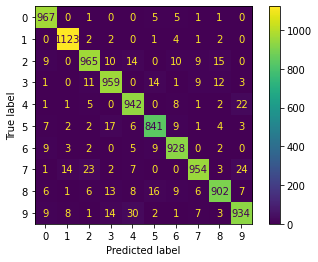

In [669]:
confusion_matrix(Y_test,predicted)

In [670]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.9511538943287418
Accuracy:0.9515
Recall:0.9511538943287418
f1 score:0.9510174726449281


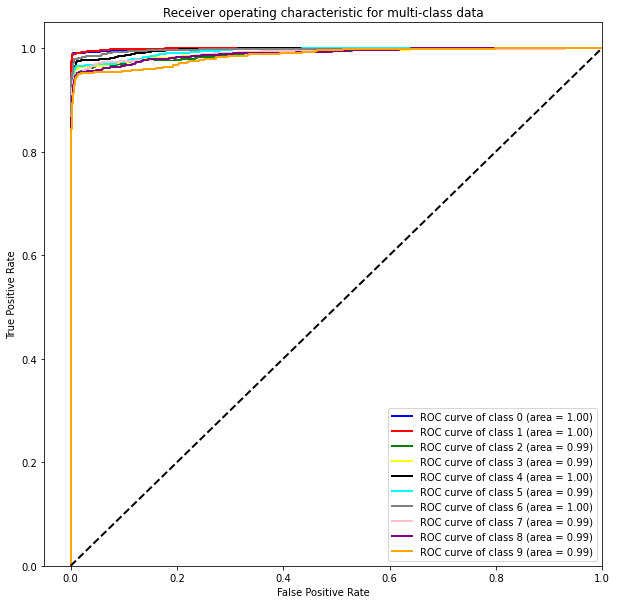

In [671]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ovr')
plot_ROC(Y_test,Y_score)

In [672]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.9929396717446153


##Imbalanced MNIST with SMOTE

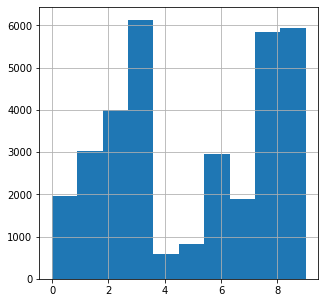

In [673]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
X_train,Y_train = Imbalanced(X_train,Y_train)
# X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.2)

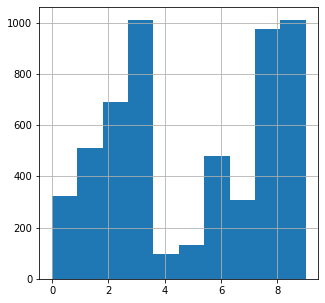

In [674]:
X_test, Y_test = Imbalanced(X_test,Y_test)

In [675]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())

In [676]:
df1 = pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count().reset_index()
df2 = pd.DataFrame({"x":Y_clean_train,"hh":[1]*len(Y_clean_train)}).groupby(["x"]).count().reset_index()

In [677]:
df1

,x,hh
0,0,6131
1,1,6131
2,2,6131
3,3,6131
4,4,6131
5,5,6131
6,6,6131
7,7,6131
8,8,6131
9,9,6131


In [678]:
print("X_train:", X_train.shape)
print("y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("y_test", Y_test.shape)

X_train: (61310, 784)
y_train: (61310,)
X_test: (5535, 784)
y_test (5535,)


In [679]:
X_train,Y_train = shuffle(X_train,Y_train)
X_test,Y_test = shuffle(X_test,Y_test)

In [680]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   20.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   58.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   58.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   58.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   58.6s finished


In [681]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       323
           1       0.97      0.99      0.98       510
           2       0.95      0.94      0.95       691
           3       0.97      0.94      0.95      1010
           4       0.64      0.94      0.76        98
           5       0.75      0.89      0.81       133
           6       0.95      0.97      0.96       479
           7       0.89      0.95      0.92       308
           8       0.96      0.93      0.95       974
           9       0.99      0.92      0.95      1009

    accuracy                           0.94      5535
   macro avg       0.90      0.95      0.92      5535
weighted avg       0.95      0.94      0.95      5535




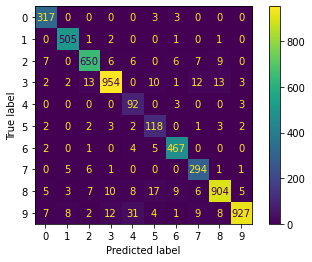

In [682]:
confusion_matrix(Y_test,predicted)

In [683]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.8998684681459261
Accuracy:0.9445347786811201
Recall:0.8998684681459261
f1 score:0.9192028643357084


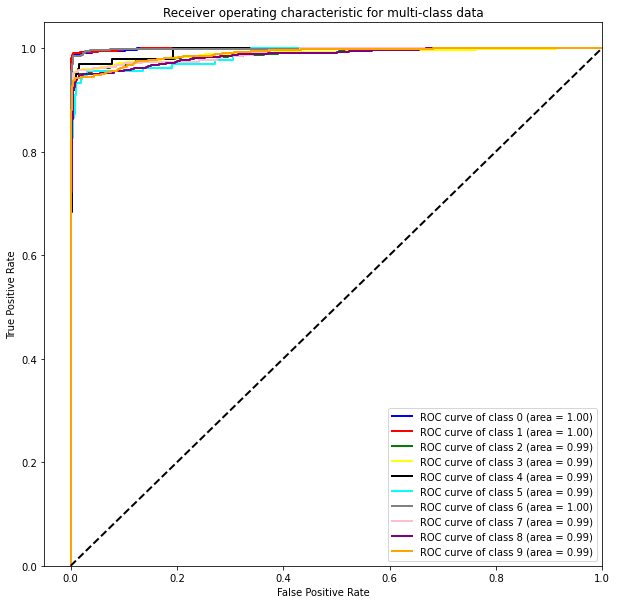

In [684]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ova')
plot_ROC(Y_test,Y_score)

In [685]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.9918956561437394


## Symmetric Noise with Balanced MNIST Dataset with SMOTE

In [686]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
# X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,train_size=0.2,random_state=23)

In [687]:
X_train,Y_train = SYM_Noise(X_train,Y_train,60)

Print noisy label generation statistics:
Noisy class 0, has 5977 samples.
Noisy class 1, has 6655 samples.
Noisy class 2, has 6021 samples.
Noisy class 3, has 6008 samples.
Noisy class 4, has 5859 samples.
Noisy class 5, has 5519 samples.
Noisy class 6, has 5939 samples.
Noisy class 7, has 6247 samples.
Noisy class 8, has 5815 samples.
Noisy class 9, has 5960 samples.


In [688]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())

In [689]:
df1 = pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count().reset_index()
df2 = pd.DataFrame({"x":Y_clean_train,"hh":[1]*len(Y_clean_train)}).groupby(["x"]).count().reset_index()

In [690]:
df1

,x,hh
0,0,6655
1,1,6655
2,2,6655
3,3,6655
4,4,6655
5,5,6655
6,6,6655
7,7,6655
8,8,6655
9,9,6655


In [691]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (66550, 784)
Y_train: (66550,)
X_test: (10000, 784)
Y_test (10000,)


In [692]:
X_train,Y_train = shuffle(X_train,Y_train)
X_test,Y_test = shuffle(X_test,Y_test)

In [693]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   49.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   49.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.1min finished


In [694]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.94      0.92      0.93      1032
           3       0.92      0.93      0.93      1010
           4       0.92      0.96      0.94       982
           5       0.93      0.92      0.92       892
           6       0.95      0.96      0.96       958
           7       0.95      0.92      0.94      1028
           8       0.94      0.90      0.92       974
           9       0.93      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000




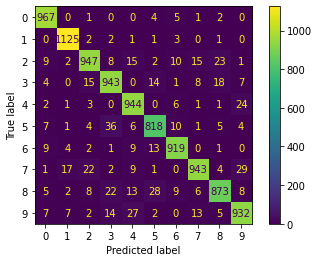

In [695]:
confusion_matrix(Y_test,predicted)

In [696]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.9405889872832652
Accuracy:0.9411
Recall:0.9405889872832652
f1 score:0.940322163979068


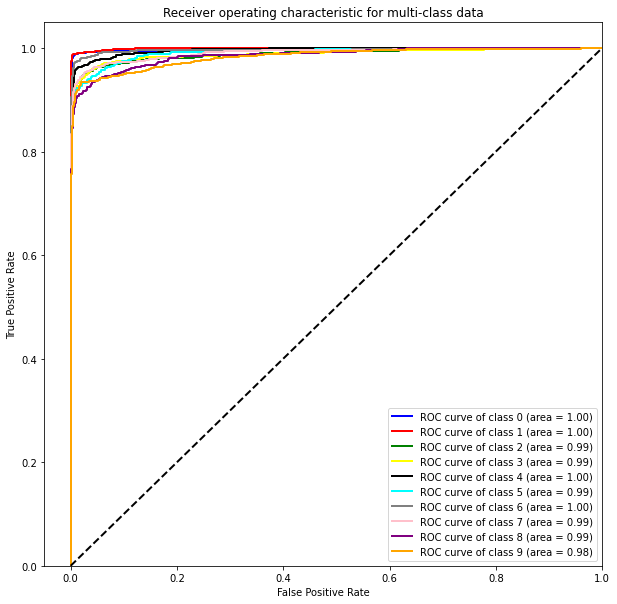

In [697]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ovr')
plot_ROC(Y_test,Y_score)

In [698]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.9915811956968215


## Asymmetric Noise with Balanced MNIST Dataset with SMOTE

In [699]:
source_class = [7, 2, 3, 5, 6, 0, 4]
target_class = [1, 7, 8, 6, 5, 4, 1]

noise_ratio = 60

In [700]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
# X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,train_size=0.2,random_state=23)

In [701]:
X_train,Y_train = ASYM_Noise(X_train,Y_train,source_class,target_class,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 3277 samples.
Noisy class 1, has 12227 samples.
Noisy class 2, has 3251 samples.
Noisy class 3, has 3364 samples.
Noisy class 4, has 5823 samples.
Noisy class 5, has 5682 samples.
Noisy class 6, has 5657 samples.
Noisy class 7, has 6152 samples.
Noisy class 8, has 8618 samples.
Noisy class 9, has 5949 samples.


In [702]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())

In [703]:
df1 = pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count().reset_index()
df2 = pd.DataFrame({"x":Y_clean_train,"hh":[1]*len(Y_clean_train)}).groupby(["x"]).count().reset_index()

In [704]:
df1

,x,hh
0,0,12227
1,1,12227
2,2,12227
3,3,12227
4,4,12227
5,5,12227
6,6,12227
7,7,12227
8,8,12227
9,9,12227


In [705]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (122270, 784)
Y_train: (122270,)
X_test: (10000, 784)
Y_test (10000,)


In [706]:
X_train,Y_train = shuffle(X_train,Y_train)
X_test,Y_test = shuffle(X_test,Y_test)

In [707]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  5.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  5.5min finished


In [708]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.93      0.99      0.96      1135
           2       0.97      0.94      0.95      1032
           3       0.93      0.94      0.94      1010
           4       0.95      0.93      0.94       982
           5       0.83      0.85      0.84       892
           6       0.89      0.85      0.87       958
           7       0.96      0.92      0.94      1028
           8       0.92      0.91      0.92       974
           9       0.92      0.93      0.93      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000




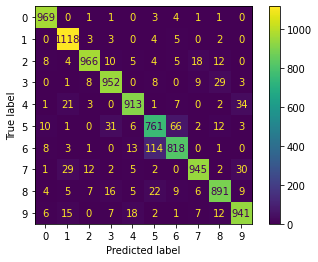

In [709]:
confusion_matrix(Y_test,predicted)

In [710]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.9262487095323129
Accuracy:0.9274
Recall:0.9262487095323129
f1 score:0.9256866777821109


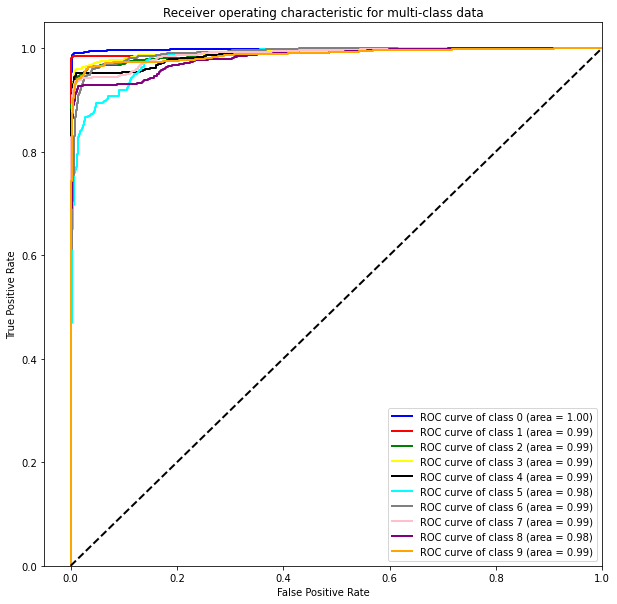

In [711]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ovr')
plot_ROC(Y_test,Y_score)

In [712]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.9890141381176477


## Symmetric Noise with Imbalanced MNIST Dataset with SMOTE

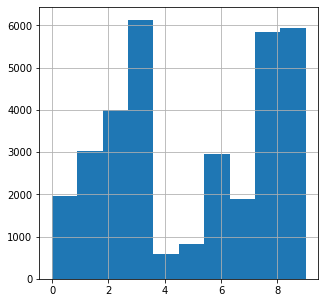

In [713]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
X_train,Y_train = Imbalanced(X_train,Y_train)
# X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=23)

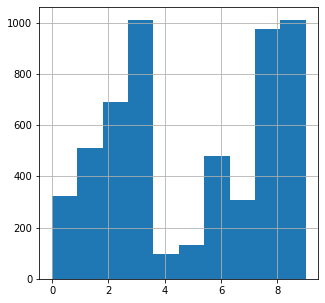

In [714]:
X_test, Y_test = Imbalanced(X_test,Y_test)

In [715]:
X_train,Y_train = SYM_Noise(X_train,Y_train,60)

Print noisy label generation statistics:
Noisy class 0, has 2050 samples.
Noisy class 1, has 2925 samples.
Noisy class 2, has 3674 samples.
Noisy class 3, has 5727 samples.
Noisy class 4, has 1415 samples.
Noisy class 5, has 1491 samples.
Noisy class 6, has 2867 samples.
Noisy class 7, has 1997 samples.
Noisy class 8, has 5429 samples.
Noisy class 9, has 5569 samples.


In [716]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())

In [717]:
X_train,Y_train = shuffle(X_train,Y_train)
X_test,Y_test = shuffle(X_test,Y_test)

In [718]:
df1 = pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count().reset_index()
df2 = pd.DataFrame({"x":Y_clean_train,"hh":[1]*len(Y_clean_train)}).groupby(["x"]).count().reset_index()

In [719]:
df1

,x,hh
0,0,5727
1,1,5727
2,2,5727
3,3,5727
4,4,5727
5,5,5727
6,6,5727
7,7,5727
8,8,5727
9,9,5727


In [720]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (57270, 784)
Y_train: (57270,)
X_test: (5535, 784)
Y_test (5535,)


In [721]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   38.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   38.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.4min finished


In [722]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       323
           1       0.91      0.99      0.95       510
           2       0.94      0.92      0.93       691
           3       0.95      0.95      0.95      1010
           4       0.24      0.26      0.25        98
           5       0.66      0.39      0.49       133
           6       0.95      0.96      0.96       479
           7       0.86      0.82      0.84       308
           8       0.95      0.89      0.92       974
           9       0.90      0.94      0.92      1009

    accuracy                           0.91      5535
   macro avg       0.82      0.81      0.81      5535
weighted avg       0.91      0.91      0.90      5535




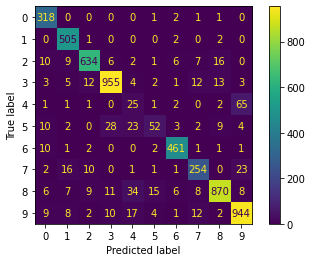

In [723]:
confusion_matrix(Y_test,predicted)

In [724]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.8214100181188971
Accuracy:0.9065943992773261
Recall:0.8214100181188971
f1 score:0.8115093137664042


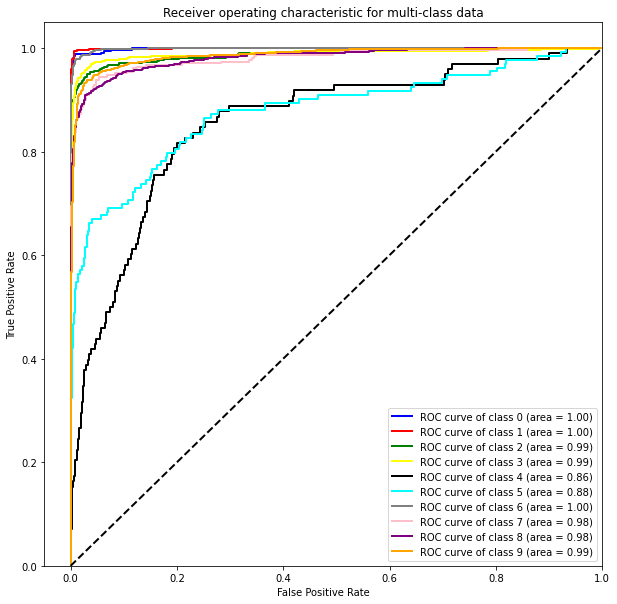

In [725]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ovr')
plot_ROC(Y_test,Y_score)

In [726]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.9655062005045055


## Asymmetric Noise with Imbalanced MNIST Dataset with SMOTE

In [727]:
source_class = [7, 2, 3, 5, 6, 0, 4]
target_class = [1, 7, 8, 6, 5, 4, 1]

noise_ratio = 60

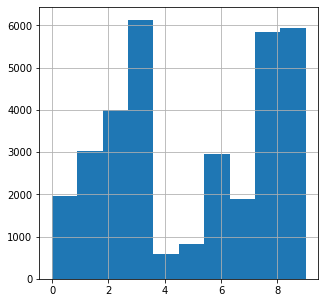

In [728]:
X_train,y_train,X_test,y_test = load_data()
X_train,Y_train,X_test,Y_test,y_train_clean,Y_clean_train,Y_clean_train = preprocess(X_train,y_train,X_test,y_test)
X_train,Y_train = Imbalanced(X_train,Y_train)
# X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=23)

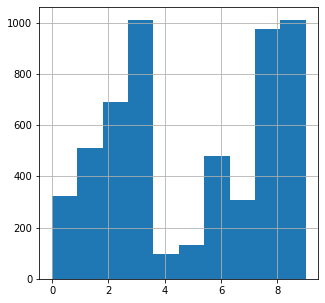

In [729]:
X_test, Y_test = Imbalanced(X_test,Y_test)

In [730]:
X_train,Y_train = ASYM_Noise(X_train,Y_train,source_class,target_class,noise_ratio)

Print noisy label generation statistics:
Noisy class 0, has 1104 samples.
Noisy class 1, has 4139 samples.
Noisy class 2, has 2186 samples.
Noisy class 3, has 3347 samples.
Noisy class 4, has 1175 samples.
Noisy class 5, has 1797 samples.
Noisy class 6, has 1975 samples.
Noisy class 7, has 2837 samples.
Noisy class 8, has 8635 samples.
Noisy class 9, has 5949 samples.


In [731]:
sm = SMOTE(random_state=2)
X_train,Y_train = sm.fit_resample(X_train,Y_train.ravel())

In [732]:
df1 = pd.DataFrame({"x":Y_train,"hh":[1]*len(Y_train)}).groupby(["x"]).count().reset_index()
df2 = pd.DataFrame({"x":Y_clean_train,"hh":[1]*len(Y_clean_train)}).groupby(["x"]).count().reset_index()

In [733]:
df1

,x,hh
0,0,8635
1,1,8635
2,2,8635
3,3,8635
4,4,8635
5,5,8635
6,6,8635
7,7,8635
8,8,8635
9,9,8635


In [734]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (86350, 784)
Y_train: (86350,)
X_test: (5535, 784)
Y_test (5535,)


In [735]:
X_train,Y_train = shuffle(X_train,Y_train)
X_test,Y_test = shuffle(X_test,Y_test)

In [736]:
predicted,clf,Y_score = train_model(X_train,Y_train,X_test,0.05)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   44.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   44.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.1min finished


In [737]:
classification_report(Y_test,predicted)

Classification report for classifier BaggingClassifier(base_estimator=SVC(), bootstrap=False, max_samples=0.05,
                  n_jobs=-1, verbose=True):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       323
           1       0.90      0.99      0.94       510
           2       0.97      0.92      0.94       691
           3       0.95      0.95      0.95      1010
           4       0.67      0.76      0.71        98
           5       0.23      0.59      0.33       133
           6       0.83      0.48      0.61       479
           7       0.87      0.87      0.87       308
           8       0.94      0.91      0.93       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.88      5535
   macro avg       0.82      0.83      0.82      5535
weighted avg       0.91      0.88      0.89      5535




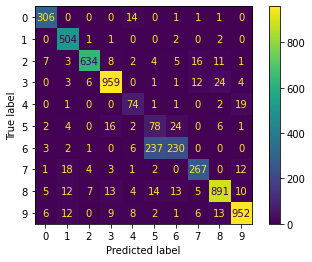

In [738]:
confusion_matrix(Y_test,predicted)

In [739]:
print("Precision:{}".format(precision_score(Y_test,predicted,average='macro')))
print("Accuracy:{}".format(accuracy_score(Y_test, predicted)))
print("Recall:{}".format(precision_score(Y_test,predicted,average='macro')))
print("f1 score:{}".format(f1_score(Y_test,predicted,average='macro')))

Precision:0.8234880075416127
Accuracy:0.8843721770551038
Recall:0.8234880075416127
f1 score:0.816257735381637


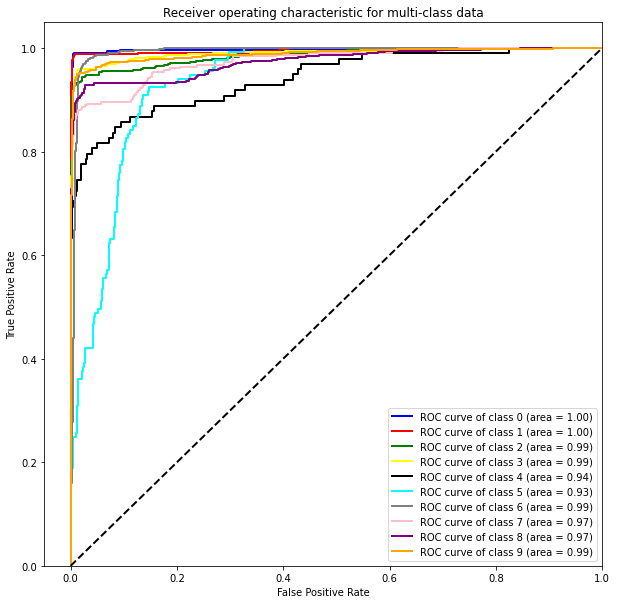

In [740]:
Y_test = label_binarize(Y_test,classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc = roc_auc_score(Y_test, Y_score,multi_class='ovr')
plot_ROC(Y_test,Y_score)

In [741]:
print("roc_auc score :{}".format(roc_auc))

roc_auc score :0.9771650319902756
